In [2]:
import sys
import os
from datetime import datetime
import json
import shutil
import random
import ast
import numpy as np
import pandas as pd
#import tensorflow as tf
#from tensorflow import keras
from tqdm import tqdm_notebook, tqdm
from matplotlib import pyplot as plt

sys.path.append('../src/')
from env import BTCMarket_Env
from agent import Trader_Agent
from DQNtrainer import DQNTrainer
from DRLtrainer import DRLTrainer
from collections import deque
import h5py
from itertools import product


2023-04-12 16:24:14.975475: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
hpo_params= { 
    'obs_space' : [(8,20)], 
    'action_domain' : [(0.0,1.0)], # (-1.0,1.0),
    'money' : [10000], 
    'fee' : [0.001], 
    'asset' : ['BTC', 'PERP'],
#    'reward_function' : ['compute_reward_from_tutor', 'reward_sharpe_ratio', 'reward_sortino_ratio', 
#                        'reward_differential_sharpe_ratio', 'reward_sterling_ratio'],
    'reward_function' : ['reward_differential_sharpe_ratio'],
    
    'learning_rate': [1e-3],
    'trainer' : ['DRLTrainer'], # 'DRLTrainer', 'DQNTrainer'
    'episodes' : [1], 
    'runs_p_eps' : [1], 
    'batch_size': [1],
    'epoch': [5],
    'gamma': [0.95],
    
    'epsilon': [0.7],
    'epsilon_final':[0.01],
    'epsilon_decay':[0.995],
}


keys, values = zip(*hpo_params.items())
hpo_list = [dict(zip(keys, v)) for v in product(*values)]
print(hpo_list)

[{'obs_space': (8, 20), 'action_domain': (0.0, 1.0), 'money': 10000, 'fee': 0.001, 'asset': 'BTC', 'reward_function': 'reward_differential_sharpe_ratio', 'learning_rate': 0.001, 'trainer': 'DRLTrainer', 'episodes': 1, 'runs_p_eps': 1, 'batch_size': 1, 'epoch': 5, 'gamma': 0.95, 'epsilon': 0.7, 'epsilon_final': 0.01, 'epsilon_decay': 0.995}, {'obs_space': (8, 20), 'action_domain': (0.0, 1.0), 'money': 10000, 'fee': 0.001, 'asset': 'PERP', 'reward_function': 'reward_differential_sharpe_ratio', 'learning_rate': 0.001, 'trainer': 'DRLTrainer', 'episodes': 1, 'runs_p_eps': 1, 'batch_size': 1, 'epoch': 5, 'gamma': 0.95, 'epsilon': 0.7, 'epsilon_final': 0.01, 'epsilon_decay': 0.995}]


In [ ]:
i = 0
#for i, param_combination in enumerate(hpo_list):
param_combination = hpo_list[0]
if param_combination.get('trainer') == 'DQNTrainer':
    action_space = 4
    algorithm = f'DQN_trial_{i}'
else:
    action_space = 1
    algorithm = f'DRL_trial_{i}'
    
param_combination['action_space'] = action_space
param_combination['algorithm'] = algorithm
print(param_combination)

env = BTCMarket_Env(observation_space = param_combination.get('obs_space', (8,20)),
        action_space = action_space,
        start_money = param_combination.get('money', 10000),
        trading_fee = param_combination.get('fee', (8,20)),
        asset = param_combination.get('asset', 'PERP'),
        reward_function = param_combination.get('reward_function', 'reward_differential_sharpe_ratio'),
                   )

agent = Trader_Agent(observation_space = param_combination.get('obs_space', (8,20)),
            action_space = action_space,
            action_domain=param_combination.get('action_domain', (0.0,1.0)),
            epsilon = param_combination.get('epsilon', 0.7),
            epsilon_final = param_combination.get('epsilon_final', 0.01),
            epsilon_decay = param_combination.get('epsilon_decay', 0.995),
                    )

trainer_class = eval(param_combination.get('trainer', 'DRLTrainer'))
trainer = trainer_class(env, agent,
            observation_space = param_combination.get('obs_space', (8,20)),
            action_space = action_space,
            batch_size=param_combination.get('batch_size', 50),
            epoch=param_combination.get('epoch', 5),
            gamma=param_combination.get('gamma', 0.95),
            learning_rate=param_combination.get('learning_rate', 1e-3),
            algorithm=algorithm,
            lstm_path="./../notebooks/best_models/11_mar_2023/best_model_sequential_20back_10ahead.h5",
            # best_model_sequential_20back_10ahead lstm_2,
                       )

os.makedirs(trainer.train_folder,exist_ok=True)
with open(f'{trainer.train_folder}/params.json', 'w') as fp:
    json.dump(param_combination, fp)
    
trainer.rollout(n_episodes=param_combination.get('episodes', 2), 
                   run_per_episode=param_combination.get('runs_p_eps', 2))

In [25]:
# Plot profit
df = pd.read_csv(f'{trainer.train_folder}/Trainer_Data.csv')
print(df.shape)
print(max(df.time_elapsed))

(669, 10)
57.83435010910034


In [26]:
df.tail(10)

,Unnamed: 0,episode,run,action,state,reward,done,epsilon,profit,time_elapsed
659,58,1,1,[0.06886604],[[[5.91458978e-01 8.99003222e-06 6.11890756e-0...,[-0.31623113],False,0.134552,-3383.38,57.189566
660,59,1,1,[0.54481226],[[[1.00000000e+00 4.07031702e-06 3.68575950e-0...,[-0.31655526],False,0.133880,-3386.50,57.316554
661,60,1,1,[0.47237195],[[[9.99999999e-01 2.48671732e-06 1.04831720e-0...,[-0.31454531],False,0.133880,-3359.84,57.318255
662,61,1,1,[0.5430898],[[[8.07777745e-19 4.20755568e-06 2.46562874e-0...,[-0.31530739],False,0.133210,-3366.50,57.444783
663,62,1,1,[0.5778488],[[[9.99998629e-01 2.09658146e-05 5.28269331e-0...,[-0.31820786],False,0.133210,-3399.42,57.489578
664,63,1,1,[0.98121418],[[[1.00000000e+00 4.07870132e-05 3.91191867e-0...,[-0.31637537],False,0.132544,-3371.78,57.578229
665,64,1,1,[0.5497357],[[[1.00000000e+00 2.35534799e-04 9.79398128e-0...,[-0.31690641],False,0.132544,-3373.23,57.621835
666,65,1,1,[0.53429186],[[[1.00024037e-04 2.45423911e-04 9.66070312e-0...,[-0.31450351],False,0.131882,-3341.13,57.746773
667,66,1,1,[0.59798647],[[[3.40706402e-10 9.42813250e-04 9.13939439e-0...,[-0.31446939],False,0.131882,-3338.83,57.748583
668,67,1,1,[0.54868966],[[[1.52455393e-20 7.80451280e-03 6.17900379e-0...,[-0.31794732],True,0.131222,-3376.82,57.834350


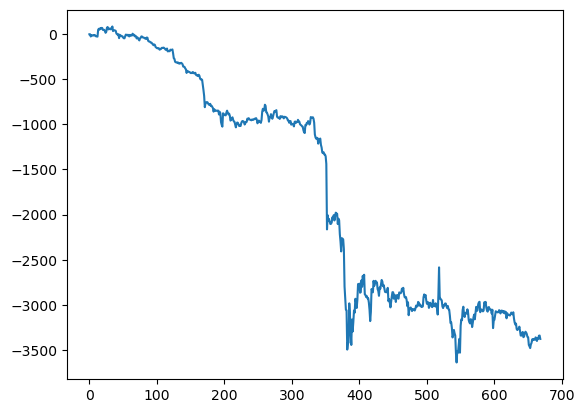

In [32]:
p = df.profit
plt.plot(df.profit)

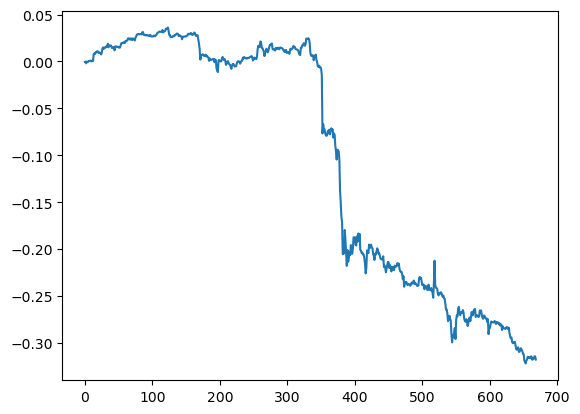

In [28]:
y = [ast.literal_eval(x)[0] for x  in df.reward]
plt.plot(y)

In [29]:
dfep = pd.read_csv(f'/Users/samuelharck/Desktop/Projekt/ai_trader/data/20230412_163929/DRL_trial_0/Epi_1_run_1.csv')

In [35]:
print(dfep.columns)
dfep.head()


Index(['Unnamed: 0', 'short_units', 'state', 'reward', 'buy_short_count',
       'btc_price', 'btc_eur', 'long_wallet', 'sell_long_count',
       'buy_long_count', 'btc_units', 'long_position', 'swap_price',
       'short_eur', 'wallet_value', 'action', 'episode', 'short_wallet',
       'sell_short_count', 'fee_paid', 'done', 'short_position', 'money',
       'funding_rate'],
      dtype='object')


,Unnamed: 0,short_units,state,reward,buy_short_count,btc_price,btc_eur,long_wallet,sell_long_count,buy_long_count,...,wallet_value,action,episode,short_wallet,sell_short_count,fee_paid,done,short_position,money,funding_rate
0,0,0,[[[0.5 0.99951551 0.5 0.5 ...,[0.],0,8865.94,0,"[0, 0]",0,0,...,10000.00,[0],1,"[0, 0]",0,0,False,-0.0,[10000],0.0001
1,1,0,[[[0.5 0.99951551 0.5 0.5 ...,[-0.00049976],0,8919.89,[4997.50124938],"[array([0.55978669]), array([8927.51])]",0,1,...,9995.00,[0.5],1,"[0, 0]",0,[4.99750125],False,-0.0,[4997.5],0.0001
2,2,0,[[[0.5 0.99951551 0.5 0.5 ...,[-0.00014476],0,8920.00,[3997.10335655],"[array([0.44774738]), array([8927.1396613])]",1,1,...,9994.83,[0.4],1,"[0, 0]",0,[1.00039789],False,-0.0,[5996.9],0.0001
3,3,0,[[[5.00000000e-01 9.99515512e-01 5.00000000e-0...,[-0.0020048],0,8869.82,[6003.90348339],"[array([0.67377605]), array([8910.82943824])]",1,2,...,9970.22,[0.6],1,"[0, 0]",0,[2.00680013],False,-0.0,[3988.09],0.0001
4,4,0,[[[5.00000000e-01 9.99515512e-01 5.00000000e-0...,[-0.00022462],0,8896.21,[3999.22795971],"[array([0.44860321]), array([8914.84469313])]",2,2,...,9984.60,[0.4],1,"[0, 0]",0,[2.00467552],False,-0.0,[5990.76],0.0001


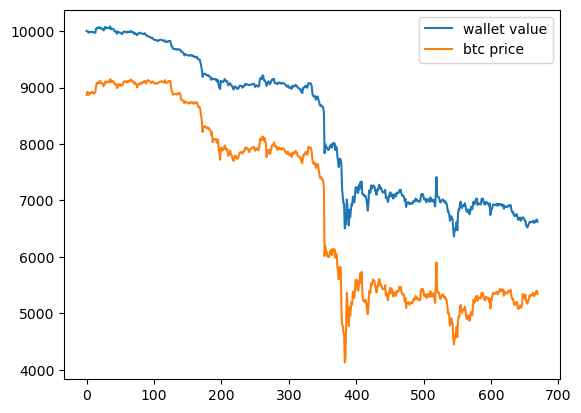

In [34]:
plt.plot(dfep.wallet_value, label='wallet value')
plt.plot(dfep.btc_price, label='btc price')
plt.legend()